# MCMC

Markov Chain Monte Carlo (MCMC) is one of the most used methods to approximate a complicated distribution. In this paper we use tow MCMC algorithm, the Metropolis-Hastings algorithm and the Gibbs Sampling algorithm.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, uniform, beta, bernoulli

In [2]:
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

## A.1 Metropolis-Hastings

In this section we use the Metropolis-Hastings (MH) algorithm to approximate empirically the distribution $p(x) \propto 2e^{-(x-2)^{2}}+e^{-|x|}+e^{-(x+2)^{2}}e^{-|x+2|}=\tilde{p}(x)$. Firstly, we chose a proposal distribution with the same support as $p(x)$, as a Gaussian proposal, i.e., $q(x^{'}|x_{i})=\mathcal{N}(x_{i}, \sigma^{2})$. Since the proposal is symmetric, the acceptance probability is given by $\alpha=\min\big(1, \frac{\tilde{p}(x')}{\tilde{p}(x_{i})}\big)$. Secondly, we draws 5000 samples from $p(x)$ using MH with $\sigma\in\{0.01, 0.1, 1, 100\}$. This is ilustrated in Figure 1. Different choices of the proposal standard deviation $\sigma$ lead to very different results. If the proposal is too narrow, only one mode of $p(x)$ might be visited. On the other hand, if it is too wide, the rejection rate can be very high, resulting in high correlations. In sum, the success or failure of the algorithm not only depends on the choice of the proposal distribution, it also depends on its parameters, in this case the adecuate $\sigma$ might be in $\{0.1, 1\}$. 

In [3]:
def p_bar(x):
    pdf = 2*np.exp(-(x-2)**2)+np.exp(-np.abs(x))
    pdf+=np.exp(-(x+2)**2)*np.exp(-np.abs(x+2))
    return pdf

def MetropolisHasting(sigma=1, n=5000, seed=0):
    # set seed
    np.random.seed(seed)
    # trace
    x = np.zeros(n+1)
    # init value
    x[0] = norm.rvs(0, sigma)
    for i in range(0,n):
        # sample x': x'~q(x'|x[i]) = Normal(x[i], sigma)
        x_ = np.random.normal(x[i], sigma)
        # compute acceptance probability
        # the term associated to q is omitted due that q is a symmetric proposal
        r = min(1, p_bar(x_)/p_bar(x[i]) )
        # sample u~sim U(0,1)
        u = uniform.rvs(0,1)
        # set new sample
        if r>u:
            x[i+1] = x_
        else:
            x[i+1] = x[i]
    return x[1:]

In [10]:
def plot_histogram(x, sigma, size):
    rows, cols = size
    x = x.reshape(rows, cols, -1)
    sigma = sigma.reshape(rows, cols)
    fig, axs = plt.subplots(2, 2, figsize=(16,9))
    for i in range(2):
        for j in range(2):
            sns.distplot(x[i,j], ax=axs[i,j],  color="darkblue")
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
            axs[i,j].set_xlim(-20,20)
            axs[i,j].set_xlabel(rf"$\sigma$={sigma[i,j]}")
    plt.show()
    return fig

In [5]:
# sampling
seed = 0
n = 5000
sigma = np.array([0.01, 0.1, 1, 100])
x = np.array([MetropolisHasting(sigma=s, n=n, seed=seed) for s in sigma])

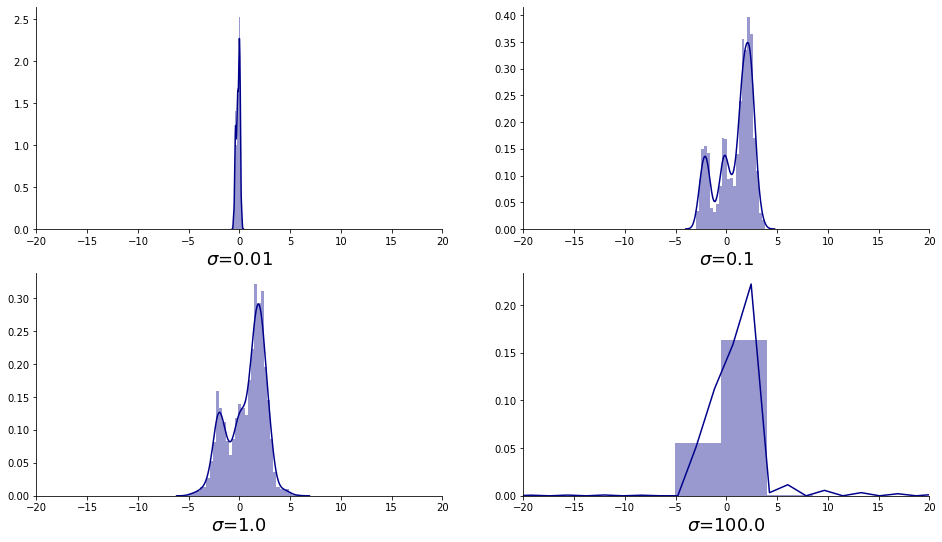

In [11]:
fig1 = plot_histogram(x, sigma, (2,2))

**Figure 1:** Approximations obtained using the MH algorithm with Gaussian proposal with different stanrdar deviation $\sigma$.

In [12]:
fig1.savefig("img/metrepolis_hastings.pdf")

## A.2 Simulated Annealing


The output of the MH algotithm can be used for point estimation, estimating quantities as mean, median or mode (the point with highest density). However, that method is not much efficient to estimate the mode because the random samples solely rarely come from the vicinity of the mode. A better way to do that is Simulated Annealing (SA). This method sampling from $p^{1/T_{i}}(x)$ instead of $p(x)$. The term $T_{i}$ is a decreasing cooling schedule with $\lim_{i\rightarrow \infty} T_{i} = 0$. To estimate the mode of $p(x)$ we set $T_{i} = Cln(i+T_{0})$, with $T_{0}=1$ and $C=2$, in this manner the series is decreasing. The result of applying SA to the previous example are shown in Figure 2. In this case the better approximation apparently is reached by $\sigma=1$, where the mode is 1.95. In brief, to obtain efficient annealed algorithms, it is again important to choose suitable proposal distributions and an appropiate cooling schedule.

In [13]:
def temperature(n, C):
    T = np.zeros(n)
    T[0] = 1
    for i in range(0, n-1):
        T[i+1]=(C*np.log(i+1+T[0]))**-1
    return T

In [14]:
def SimulatedAnnealing(sigma=1, n=5000, seed=0):
    # set seed
    np.random.seed(seed)
    # trace
    x = np.zeros(n+1)
    # temperature
    T = np.zeros(n+1)
    # init values
    x[0] = norm.rvs(0, sigma)
    T[0] = 1
    C = 2
    for i in range(0,n):
        # sample x': x'~q(x'|x[i]) = Normal(x[i], sigma)
        x_ = np.random.normal(x[i], sigma)
        # compute acceptance probability
        # the term associated to q is omitted due that q is a symmetric proposal
        r = min(1, (p_bar(x_)/p_bar(x[i]))**(1/T[i]) )
        # sample u~sim U(0,1)
        u = uniform.rvs(0,1)
        # set new sample
        if r>u:
            x[i+1] = x_
        else:
            x[i+1] = x[i]
        # update temperature
        T[i+1]=(C*np.log(i+1+T[0]))**-1
    return x[1:]

In [15]:
# sampling
x = np.array([SimulatedAnnealing(sigma=s, n=n, seed=seed) for s in sigma])

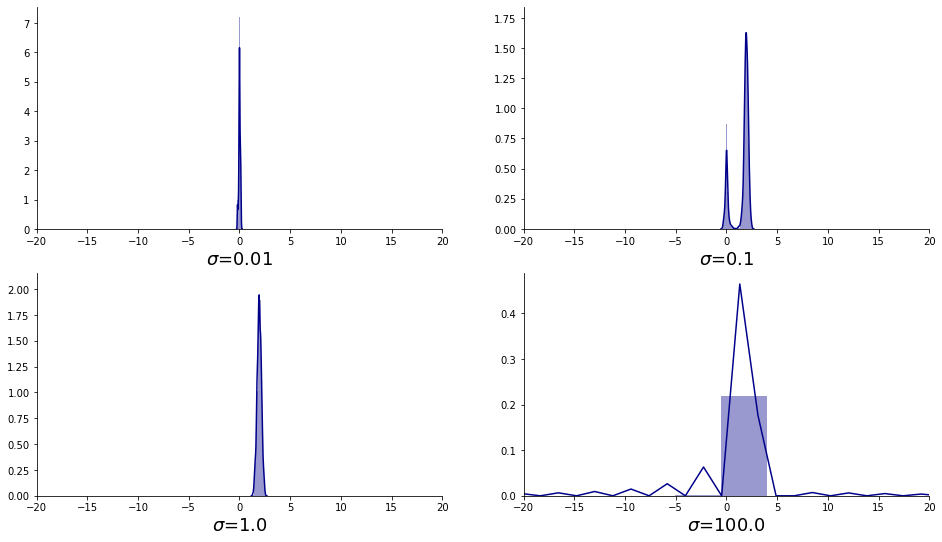

In [16]:
fig2 = plot_histogram(x, sigma, (2,2))

**Figure2 :** Discovering the modes of the target distribution using the SA algorithm.

In [17]:
fig2.savefig("img/simulated_annealing.pdf")

In [18]:
x.mean(axis=1)

array([0.00663812, 1.56923655, 1.94902959, 1.96705204])

## B. Gibbs Sampling

In this section we use the Gibbs Sampling (GB) algorithm to empirically approximate $p(z,\pi, \mu|x)$, where $x=x_{1}, \ldots, x_{100}$ is the data, $z=z_{1}, \ldots, z_{100}$ are the hiddens variables, in this case are the binary cluster assignments, $\pi$ is the mixture proportion, and $\mu=[\mu_{0}, \mu_{1}]$ are the parameters of the observation model. The generative process is detailed below: 

\begin{align}
\mu_{0}, \mu_{1} &\sim \mathcal{N}(0,5)\\
\pi&\sim Beta(0.8,0.8)\\
z_{1}, \ldots, z_{100}|\mu, \pi &\sim Bernoulli(\pi)\\
z_{i} &\sim \mathcal{N}(\mu_{z_{i}, 0.25}) 
\end{align}

Firstly, we generate a random sample from this process. In this case the resulting main parameters are $\mu_{0}=2.357$, $mu_{1}=-5.955$ and $\pi=0.788$. This is ilustrated in Figure 3. Secondly, is necessary to get the full conditional distribution $p(z_{i}|z_{-i}, \pi, \mu, x)$, $p(\mu_{k}|z, \pi, \mu_{-k}, x)$ and $p(\pi|z, \mu, x)$. The variable $z_{i}$ is conditional independent from $z_{-i}$ and $x_{-i}$ given $x_{i}$, so $p(z_{i}|z_{-i}, \pi, \mu, x)$ can be written as follows

\begin{align}
p(z_{i}=0|\pi, \mu, x_{i}) &=  (1-\pi) \mathcal{N}(x_{i}|\mu_{0}, 0.25) = \alpha_{0}\\
p(z_{i}=1|\pi, \mu, x_{i}) &=  \pi \mathcal{N}(x_{i}|\mu_{1}, 0.25) = \alpha_{1}\\
p(z_{i}|\pi, \mu, x_{i}) &\sim Bernoulli(\frac{\alpha_{1}}{\alpha_{0}+\alpha_{1}})
\end{align}

; the variable $\pi$ is conditional independent from $\mu$ and $x$ given $z$, then the full conditional is

\begin{align}
    p(\pi|z, \mu, x) &= Beta(0.8+N_{1}, 0.8+N_{0})\\
    N_{0} = \sum_{i=1, z_{i}=0}^{100}1&, \; N_{1} = \sum_{i=1, z_{i}=1}^{100}1
\end{align}

; and $\mu_{i}$ is independent from $\mu_{-i}$ and $\pi$ given $z$ and $x$, then the full conditional is
\begin{align}
    \sigma_{0}^{2} = \bigg(\frac{1}{5^{2}}+\frac{N_{0}}{0.25^{2}}\bigg)^{-1}&, \; \sigma_{1}^{2} = \bigg(\frac{1}{5^{2}}+\frac{N_{1}}{0.25^{2}}\bigg)^{-1}\\
    m_{0} = \sigma_{0}^{2}\bigg(\frac{\sum_{i=1, z_{i}=0}^{100}x_{i}}{0.25^{2}}\bigg)&, \; m_{1} = \sigma_{1}^{2}\bigg(\frac{\sum_{i=1, z_{i}=1}^{100}x_{i}}{0.25^{2}}\bigg)\\
    p(\mu_{0}|z, x) \sim \mathcal{N}(m_{0}, \sigma_{0}) &, \; p(\mu_{1}|z, x) \sim \mathcal{N}(m_{1}, \sigma_{1})
\end{align}
With all previous full conditionals we can implement the Gibbs sampling algorithm.


Finally, the results  is illustrated in Figure 4-5, where we can observe that the algorithms fastly converge to a negihborhood of the target parameters used to draw the data. The expected value approximation, i.e., the sample mean, are $\pi=0.770$, $\mu_{0}=2.275$ and $\mu_{1}=-5.954$, very close to the original values. To sum up, the Gibbs Sampling algorithm is an excellent algorithm to approximate complicated densities with a directed graph structure that encodes the conditional indepedencies in the model.



In [22]:
def SamplingMixtureTwoNormal(n=100, seed=1234):
        np.random.seed(seed)
        mu = norm.rvs(loc=0, scale=5, size=2)
        pi = beta.rvs(a=0.8, b=0.8)
        z = bernoulli.rvs(p=pi, size=n)
        x = np.array([norm.rvs(mu[z[i]], 0.25) for i in range(n)])
        return mu, pi, z, x

In [23]:
# samplin mixture of two normal
mu, pi, z, x = SamplingMixtureTwoNormal(n=100, seed=1234)
print(f"mu_0={mu[0].round(3)}, mu_1={mu[1].round(3)}, pi={pi.round(3)}")

mu_0=2.357, mu_1=-5.955, pi=0.788


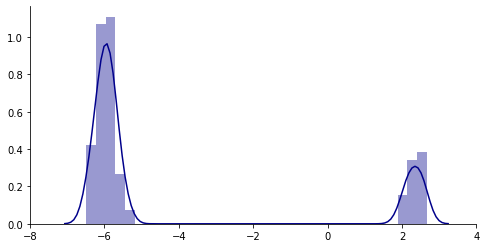

In [24]:
fig3, axs = plt.subplots(1, 1, figsize=(8,4))
sns.distplot(x, ax=axs,  color="darkblue")
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlim(-8,4)
plt.show()

**Figure 3:** Random sample of a mixture of two Gaussians.

In [25]:
fig3.savefig("img/gaussian_mixture.pdf")

In [26]:
def GibbSampling(x, n=1000, seed=0):
    # set seed
    np.random.seed(seed)
    
    # init values
    N = len(x)
    mu = [x.mean(), x.mean()]
    pi = 0.5
    z = bernoulli.rvs(p=pi, size=N)
    
    # trace
    trace = {"mu":np.zeros((n,2)), "pi":np.zeros(n), "z":np.zeros((n,N))}
    
    for i in range(0, n):
        
        # sampling hidden variables
        for j in range(0,N):
            alpha0 = (1-pi)*norm.pdf(x[j], mu[0], 0.25)
            alpha1 = pi*norm.pdf(x[j], mu[1], 0.25)
            z[j]= bernoulli.rvs(p=alpha1/(alpha0+alpha1))
        
        # sampling weight
        N_1 = z.sum()
        N_0 = N-N_1
        pi = beta.rvs(a=0.8+N_1, b=0.8+N_0)
       
        # sampling means
        sigma_0 = (1/5**2+N_0/0.25**2)**(-1/2)
        sigma_1 = (1/5**2+N_1/0.25**2)**(-1/2)
        mu_0 = sigma_0**2*(x[z==0].sum()/0.25**2)
        mu_1 = sigma_1**2*(x[z==1].sum()/0.25**2)
        mu[0] = norm.rvs(mu_0, sigma_0)
        mu[1] = norm.rvs(mu_1, sigma_1)
        
        # update trace
        trace["mu"][i] = mu
        trace["pi"][i] = pi
        trace["z"][i] = z
    return trace

In [27]:
trace =  GibbSampling(x, n=100, seed=0)

In [28]:
trace["pi"].mean()

0.7702959404434625

In [29]:
trace["mu"].mean(axis=0)

array([ 2.27471038, -5.95417496])

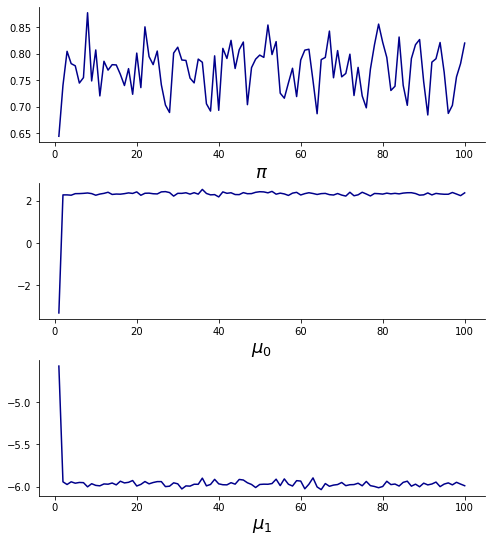

In [30]:
fig4, axs = plt.subplots(3, 1, figsize=(8,9))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axs[0].plot(list(range(1,101)), trace["pi"],  color="darkblue")
axs[1].plot(list(range(1,101)), trace["mu"][:,0],  color="darkblue")
axs[2].plot(list(range(1,101)), trace["mu"][:,1],  color="darkblue")
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[0].set_xlabel(rf"$\pi$")
axs[1].set_xlabel(rf"$\mu_{0}$")
axs[2].set_xlabel(rf"$\mu_{1}$")
plt.show()

**Figure 4:** Posterior samples drawn from the Gibbs Sampling algorithm.

In [46]:
fig4.savefig("img/gibbs_sampling_walk.pdf")

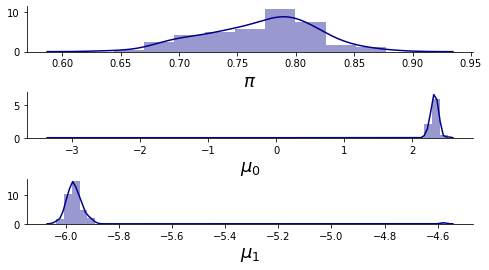

In [44]:
fig5, axs = plt.subplots(3, 1, figsize=(8,4))
plt.subplots_adjust(hspace=0.9, wspace=0.3)
sns.distplot(trace["pi"], ax=axs[0],  color="darkblue")
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
sns.distplot(trace["mu"][:,0], ax=axs[1],  color="darkblue")
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
sns.distplot(trace["mu"][:,1], ax=axs[2],  color="darkblue")
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[0].set_xlabel(rf"$\pi$")
axs[1].set_xlabel(rf"$\mu_{0}$")
axs[2].set_xlabel(rf"$\mu_{1}$")
plt.show()

In [45]:
fig5.savefig("img/gibbs_sampling_density.pdf")

**Figure 5:** Posterior approximation from the Gibbs Sampling algorithm.